In [2]:
!pip install auto-sklearn
import sklearn.datasets

import autosklearn.regression

In [3]:
# Importar librerías necesaias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

In [4]:
# Función para convertir fechas numéricas a un formato correcto
custom_date_parser = lambda x: datetime.strptime(x, "%d/%m/%Y")
divorcios = pd.read_csv("divorcios.csv", parse_dates=['fecha_divorcio', 'fecha_matrimonio'], date_parser=custom_date_parser)

In [5]:
divorcios.head()

,fecha_divorcio,tipo_divorcio,nacionalidad_h,fecha_nacimiento_h,lugar_nacimiento_h,municipio_nacimiento_h,estado_nacimiento_h,pais_nacimiento_h,edad_h,municipio_residencia_h,estado_residencia_h,pais_residencia_h,ingreso_mensual_h,ocupacion_h,lugar_residencia_h,nacionalidad_m,fecha_nacimiento_m,lugar_nacimiento_m,municipio_nacimiento_m,estado_nacimiento_m,pais_nacimiento_m,edad_m,lugar_residencia_m,municipio_residencia_m,estado_residencia_m,pais_residencia_m,ocupacion_m,ingreso_mensual_m,fecha_matrimonio,municipio_certificado,estado_certificado,nivel_educacion_h,estatus_empleo_h,nivel_educacion_m,estatus_empleo_m,duracion_matrimonio,duracion_matrimonio_meses,numero_hijos,custodia
0,2006-06-09,Necesario,MEXICANA,18/12/1975,XALAPA - ENRIQUEZ,XALAPA,VERACRUZ,MEXICO,30.0,XALAPA,VERACRUZ,MEXICO,2000.0,PINTOR,XALAPA-ENRIQUEZ,MEXICANA,08/01/1983,PUEBLA,PUEBLA,PUEBLA,MEXICO,22.0,XALAPA-ENRIQUEZ,XALAPA,VERACRUZ,MEXICO,EMPLEADA,1800.0,2000-06-26,XALAPA,VERACRUZ,SECUNDARIA,OBRERO,SECUNDARIA,EMPLEADO,5.0,NaN,1.0,NaN
1,2000-02-01,Voluntario,MEXICANA,NaN,NaN,NaN,NaN,NaN,47.0,NaN,NaN,NaN,NaN,NaN,NaN,MEXICANA,NaN,NaN,NaN,NaN,NaN,41.0,NaN,NaN,NaN,NaN,NaN,NaN,1977-02-17,XALAPA,VERACRUZ,PREPARATORIA,ESTABLECIMIENTO,PREPARATORIA,EMPLEADO,NaN,NaN,NaN,NaN
2,2005-02-01,Necesario,MEXICANA,22/02/1955,XALAPA - ENRIQUEZ,XALAPA,VERACRUZ,MEXICO,49.0,NaN,NaN,NaN,NaN,MEDICO,NaN,MEXICANA,21/03/1947,XALAPA-ENRIQUEZ,XALAPA,VERACRUZ,MEXICO,57.0,XALAPA-ENRIQUEZ,XALAPA,VERACRUZ,MEXICO,JUBILADA,NaN,1975-12-18,XALAPA,VERACRUZ,PREPARATORIA,OBRERO,NaN,TRABAJADOR POR CUENTA PROPIA EN VIA PUBLICA,NaN,NaN,NaN,NaN
3,2006-02-01,Necesario,MEXICANA,20/01/1964,XALAPA - ENRIQUEZ,XALAPA,VERACRUZ,MEXICO,42.0,XALAPA,VERACRUZ,MEXICO,6000.0,EMPLEADO,XALAPA-ENRIQUEZ,MEXICANA,NaN,XALAPA-ENRIQUEZ,XALAPA,VERACRUZ,MEXICO,NaN,XALAPA-ENRIQUEZ,XALAPA,VERACRUZ,MEXICO,COMERCIANTE,5000.0,1987-12-03,XALAPA,VERACRUZ,PROFESIONAL,EMPLEADO,PREPARATORIA,EMPLEADO,18.0,NaN,2.0,MADRE
4,2006-02-01,Necesario,MEXICANA,30/10/1975,XALAPA - ENRIQUEZ,XALAPA,VERACRUZ,MEXICO,30.0,COATEPEC,VERACRUZ,MEXICO,18000.0,MEDICO,COATEPEC,MEXICANA,13/10/1978,XALAPA-ENRIQUEZ,XALAPA,VERACRUZ,MEXICO,27.0,COATEPEC,COATEPEC,VERACRUZ,MEXICO,AMA DE CASA,NaN,1998-11-14,XALAPA,VERACRUZ,PROFESIONAL,EMPLEADO,PREPARATORIA,NO TRABAJA,7.0,NaN,2.0,MADRE


In [195]:
from pprint import pprint
pprint(list(divorcios.columns))

['fecha_divorcio',
 'tipo_divorcio',
 'edad_h',
 'ocupacion_h',
 'edad_m',
 'ocupacion_m',
 'fecha_matrimonio',
 'nivel_educacion_h',
 'estatus_empleo_h',
 'nivel_educacion_m',
 'estatus_empleo_m',
 'duracion_matrimonio',
 'numero_hijos',
 'viven_juntos',
 'diferencia_edades']


In [6]:
print(divorcios.shape)

(4923, 39)


## Limpieza de datos

Antes de comenzar a hacer cualquier tipo de análisis exploratorio, es necesario limpiar los datos. Así evitaremos tener algún tipo de sesgo o comportamiento extraño en las métricas y gráficos que realicemos.

Comencemos eliminando algunas filas y columnas.

### Nacionalidad de la pareja

Observemos qué nacionalidad predomina más entre las parejas de nuestro set de datos

In [7]:
divorcios.groupby("nacionalidad_h")[["nacionalidad_h", "nacionalidad_m"]].count()

,nacionalidad_h,nacionalidad_m
nacionalidad_h,,
ALEMANA,2,2
ARGENTINA,4,4
AUSTRALIANA,1,1
AUSTRIACA,1,1
CANADIENSE,2,2
CHILENA,1,1
CHINA,1,1
COLOMBIANA,1,1
COSTARRICENSE,1,1


In [8]:
num_mexicanos_h = divorcios.groupby("nacionalidad_h")["nacionalidad_h"].count().max()
total = divorcios.groupby("nacionalidad_h")["nacionalidad_h"].count().sum()
print("Proporcion de mexicanos en el total", num_mexicanos_h/total)

Proporcion de mexicanos en el total 0.9912637139374239


Podemos observar que la gran mayoria de los matrimonios tienen integrantes mexicanos, un 99%. Por lo que podríamos prescindir de esta característica y estar seguros que solo se analizarán matrimonios entre mexicanos.

In [9]:
divorcios = divorcios[divorcios["nacionalidad_h"] == "MEXICANA"]
divorcios = divorcios[divorcios["nacionalidad_m"] == "MEXICANA"]
divorcios.groupby("nacionalidad_h")[["nacionalidad_h", "nacionalidad_m"]].count()

,nacionalidad_h,nacionalidad_m
nacionalidad_h,,
MEXICANA,4848,4848


Dado que ahora solo contamos con matrimonios mexicanos, no tiene caso conservar estas columnas.

In [10]:
columnas_a_eliminar = ["nacionalidad_h", "nacionalidad_m"]
divorcios = divorcios.drop(columns=columnas_a_eliminar, axis=1)

Algo similar pasa con las columnas que indican el lugar de nacimiento (que se deriva en Municipio, Estado y Pais)
Pero tal vez nos interese agregar alguna columna que nos diga si la pareja vivia en la misma ciudad.

In [11]:
divorcios[divorcios["lugar_residencia_h"] != divorcios["lugar_residencia_m"]][["lugar_residencia_h", "lugar_residencia_m"]].head()

,lugar_residencia_h,lugar_residencia_m
1,NaN,NaN
2,NaN,XALAPA-ENRIQUEZ
6,XALAPA-ENRIQUEZ,PIEDRA DE AGUA
8,CIUDAD VALLES,XALAPA-ENRIQUEZ
16,NaN,NaN


In [12]:
print(divorcios["lugar_residencia_h"].isnull().sum())
print(divorcios["lugar_residencia_m"].isnull().head())

307
0    False
1     True
2    False
3    False
4    False
Name: lugar_residencia_m, dtype: bool


Eliminar las filas que tienen valores faltantes en las columnas anteriores, conllevaría a deshacernos de 600 muestras, asi que, para fines prácticos, cuando se tenga algún valor faltante en una de estas dos columnas, asumiremos que la pareja vive en la misma ciudad.

### Creando la nueva columna: viven_juntos
Esto permite reducir la dimensionalidad de nuestros datos y agrega un valor, ya que esta característica podría ser crucial en un matrimonio.

In [13]:
def establecer_viven_juntos(df):
    contador = 0
    if df["lugar_residencia_h"] == ["lugar_residencia_h"]:
        return 1   # True
    if pd.isnull(df["lugar_residencia_h"]) or pd.isnull(df["lugar_residencia_m"]):
        return 1
    else:
        return 0

divorcios["viven_juntos"] = divorcios.apply(establecer_viven_juntos, axis=1)

Ahora podemos añadir estas dos columnas (además de todas las referentes a lugares) a la lista de columnas que eliminaremos.

In [14]:
divorcios.columns

Index(['fecha_divorcio', 'tipo_divorcio', 'fecha_nacimiento_h',
       'lugar_nacimiento_h', 'municipio_nacimiento_h', 'estado_nacimiento_h',
       'pais_nacimiento_h', 'edad_h', 'municipio_residencia_h',
       'estado_residencia_h', 'pais_residencia_h', 'ingreso_mensual_h',
       'ocupacion_h', 'lugar_residencia_h', 'fecha_nacimiento_m',
       'lugar_nacimiento_m', 'municipio_nacimiento_m', 'estado_nacimiento_m',
       'pais_nacimiento_m', 'edad_m', 'lugar_residencia_m',
       'municipio_residencia_m', 'estado_residencia_m', 'pais_residencia_m',
       'ocupacion_m', 'ingreso_mensual_m', 'fecha_matrimonio',
       'municipio_certificado', 'estado_certificado', 'nivel_educacion_h',
       'estatus_empleo_h', 'nivel_educacion_m', 'estatus_empleo_m',
       'duracion_matrimonio', 'duracion_matrimonio_meses', 'numero_hijos',
       'custodia', 'viven_juntos'],
      dtype='object')

In [15]:
columnas_a_eliminar = ["lugar_residencia_h", "lugar_residencia_m", "lugar_nacimiento_h", "lugar_nacimiento_m",
                       "municipio_nacimiento_h", "municipio_nacimiento_m", "estado_nacimiento_h", "estado_nacimiento_m",
                       "pais_nacimiento_h", "pais_nacimiento_m", "municipio_residencia_h", "municipio_residencia_m",
                       "estado_residencia_h", "estado_residencia_m", "pais_residencia_h", "pais_residencia_m"]
divorcios = divorcios.drop(columns=columnas_a_eliminar, axis=1)

In [16]:
divorcios.head()

,fecha_divorcio,tipo_divorcio,fecha_nacimiento_h,edad_h,ingreso_mensual_h,ocupacion_h,fecha_nacimiento_m,edad_m,ocupacion_m,ingreso_mensual_m,fecha_matrimonio,municipio_certificado,estado_certificado,nivel_educacion_h,estatus_empleo_h,nivel_educacion_m,estatus_empleo_m,duracion_matrimonio,duracion_matrimonio_meses,numero_hijos,custodia,viven_juntos
0,2006-06-09,Necesario,18/12/1975,30.0,2000.0,PINTOR,08/01/1983,22.0,EMPLEADA,1800.0,2000-06-26,XALAPA,VERACRUZ,SECUNDARIA,OBRERO,SECUNDARIA,EMPLEADO,5.0,NaN,1.0,NaN,0
1,2000-02-01,Voluntario,NaN,47.0,NaN,NaN,NaN,41.0,NaN,NaN,1977-02-17,XALAPA,VERACRUZ,PREPARATORIA,ESTABLECIMIENTO,PREPARATORIA,EMPLEADO,NaN,NaN,NaN,NaN,1
2,2005-02-01,Necesario,22/02/1955,49.0,NaN,MEDICO,21/03/1947,57.0,JUBILADA,NaN,1975-12-18,XALAPA,VERACRUZ,PREPARATORIA,OBRERO,NaN,TRABAJADOR POR CUENTA PROPIA EN VIA PUBLICA,NaN,NaN,NaN,NaN,1
3,2006-02-01,Necesario,20/01/1964,42.0,6000.0,EMPLEADO,NaN,NaN,COMERCIANTE,5000.0,1987-12-03,XALAPA,VERACRUZ,PROFESIONAL,EMPLEADO,PREPARATORIA,EMPLEADO,18.0,NaN,2.0,MADRE,0
4,2006-02-01,Necesario,30/10/1975,30.0,18000.0,MEDICO,13/10/1978,27.0,AMA DE CASA,NaN,1998-11-14,XALAPA,VERACRUZ,PROFESIONAL,EMPLEADO,PREPARATORIA,NO TRABAJA,7.0,NaN,2.0,MADRE,0


### Eliminando columnas de fecha de nacimiento de las parejas
Al analizar la distribución de los meses, dias y años de los divorciados, se observó que no existe alguno predominante en los divorcos. Asi que no tiene caso conservar estas columnas, ya que no nos dicen nada.

In [17]:
columnas_a_eliminar = ["fecha_nacimiento_m", "fecha_nacimiento_h"]
divorcios = divorcios.drop(columns=columnas_a_eliminar, axis=1)

### Eliminando columnas referentes a la ubicación donde fue expedido el certificado de divorcio
Realmente conocer esto no nos interesa demasiado, ya que este análisis se basa más en analizar las causas de los divorcios.

In [18]:
columnas_a_eliminar = ["municipio_certificado", "estado_certificado"]
divorcios = divorcios.drop(columns=columnas_a_eliminar, axis=1)

In [19]:
divorcios.columns

Index(['fecha_divorcio', 'tipo_divorcio', 'edad_h', 'ingreso_mensual_h',
       'ocupacion_h', 'edad_m', 'ocupacion_m', 'ingreso_mensual_m',
       'fecha_matrimonio', 'nivel_educacion_h', 'estatus_empleo_h',
       'nivel_educacion_m', 'estatus_empleo_m', 'duracion_matrimonio',
       'duracion_matrimonio_meses', 'numero_hijos', 'custodia',
       'viven_juntos'],
      dtype='object')

## Manejando los valores faltantes

Es importante que nuestro set de datos no contenga valores, faltantes, ya que estos pueden afectar el análisis y las métricas que obtengamos.

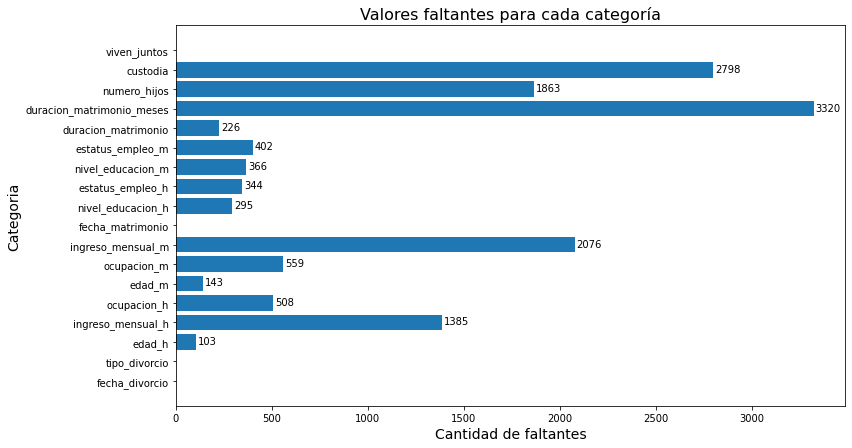

In [20]:
def plot_na(df):
    na_info = df.isna().sum()
    categorias = na_info.index
    valores = na_info.array
    plt.figure(figsize=(12, 7))
    plt.barh(categorias, valores, align='center')
    plt.title('Valores faltantes para cada categoría', fontsize=16)
    plt.ylabel('Categoria', fontsize=14)
    plt.xlabel('Cantidad de faltantes', fontsize=14)
    for index, data in enumerate(valores):
        if data != 0:
            plt.text(x = data+10, y = index-0.10, s=f'{data}')
    plt.show()

plot_na(divorcios)

### Nos desharemos de las siguientes categorias:
- Custodia
- Ingreso mensual del hombre
- Ingreso mensual de la mujer

Debido a que estos tienen demasiados valores faltantes y podrían afectar nuestras predicciones y análisis.

In [21]:
columnas_a_eliminar = ["custodia", "ingreso_mensual_m", "ingreso_mensual_h"]
divorcios = divorcios.drop(columns=columnas_a_eliminar, axis=1)

### Duración del matrimonio
Primero cabe señalar que podriamos eliminar la duración del matrimonio en meses, y dejar solo la que indica la duración en años. Para lidiar los valores faltantes en la columna anterior, utilizaremos la diferencia entre las fechas de matrimonio y la de divorcio.

In [22]:
divorcios = divorcios.drop(columns=["duracion_matrimonio_meses"], axis=1)
divorcios["duracion_matrimonio"] = np.floor((pd.to_datetime(divorcios['fecha_divorcio']) - 
                                             pd.to_datetime(divorcios['fecha_matrimonio'])).dt.days / 365.25)

In [23]:
divorcios.head()

,fecha_divorcio,tipo_divorcio,edad_h,ocupacion_h,edad_m,ocupacion_m,fecha_matrimonio,nivel_educacion_h,estatus_empleo_h,nivel_educacion_m,estatus_empleo_m,duracion_matrimonio,numero_hijos,viven_juntos
0,2006-06-09,Necesario,30.0,PINTOR,22.0,EMPLEADA,2000-06-26,SECUNDARIA,OBRERO,SECUNDARIA,EMPLEADO,5.0,1.0,0
1,2000-02-01,Voluntario,47.0,NaN,41.0,NaN,1977-02-17,PREPARATORIA,ESTABLECIMIENTO,PREPARATORIA,EMPLEADO,22.0,NaN,1
2,2005-02-01,Necesario,49.0,MEDICO,57.0,JUBILADA,1975-12-18,PREPARATORIA,OBRERO,NaN,TRABAJADOR POR CUENTA PROPIA EN VIA PUBLICA,29.0,NaN,1
3,2006-02-01,Necesario,42.0,EMPLEADO,NaN,COMERCIANTE,1987-12-03,PROFESIONAL,EMPLEADO,PREPARATORIA,EMPLEADO,18.0,2.0,0
4,2006-02-01,Necesario,30.0,MEDICO,27.0,AMA DE CASA,1998-11-14,PROFESIONAL,EMPLEADO,PREPARATORIA,NO TRABAJA,7.0,2.0,0


### Número de hijos
Sin duda, en un matrimonio, la cantidad de hijos es una característica bastante importante. En nuestro set de datos, podemos obervar que hay aproximadamente la mitad de valores faltantes en esta característica. Vamos a asumir que cuando existe un valor faltante, se refiere a que el matrimonio tenía cero hijos, ya que el cero no se encuentra entre los valores únicos de esta columna y sería lógico pensar que el capturista decidió dejar vacía esta casilla cuando el matrimonio no reportaba ningun hijo.

In [24]:
divorcios["numero_hijos"] = divorcios["numero_hijos"].fillna(0)

### Edad de la pareja
Tenemos algunos valores faltantes en esta categoría. Deseamos obtener una nueva columna a partir de estas dos llamada "diferencia_edad" para condensar estas dos características en una.
Para no afectar el cálculo de esta nueva columna, eliminaremos las muestras que tengan valores faltantes en las columnas:
- Edad de la compañera
- Edad del compañero

In [25]:
divorcios = divorcios[divorcios["edad_m"].notna()]
divorcios = divorcios[divorcios["edad_h"].notna()]

In [26]:
divorcios["diferencia_edades"] = abs(divorcios["edad_m"] - divorcios["edad_h"])
divorcios.head()

,fecha_divorcio,tipo_divorcio,edad_h,ocupacion_h,edad_m,ocupacion_m,fecha_matrimonio,nivel_educacion_h,estatus_empleo_h,nivel_educacion_m,estatus_empleo_m,duracion_matrimonio,numero_hijos,viven_juntos,diferencia_edades
0,2006-06-09,Necesario,30.0,PINTOR,22.0,EMPLEADA,2000-06-26,SECUNDARIA,OBRERO,SECUNDARIA,EMPLEADO,5.0,1.0,0,8.0
1,2000-02-01,Voluntario,47.0,NaN,41.0,NaN,1977-02-17,PREPARATORIA,ESTABLECIMIENTO,PREPARATORIA,EMPLEADO,22.0,0.0,1,6.0
2,2005-02-01,Necesario,49.0,MEDICO,57.0,JUBILADA,1975-12-18,PREPARATORIA,OBRERO,NaN,TRABAJADOR POR CUENTA PROPIA EN VIA PUBLICA,29.0,0.0,1,8.0
4,2006-02-01,Necesario,30.0,MEDICO,27.0,AMA DE CASA,1998-11-14,PROFESIONAL,EMPLEADO,PREPARATORIA,NO TRABAJA,7.0,2.0,0,3.0
5,2006-02-01,Necesario,32.0,EMPLEADO,29.0,NaN,1995-01-20,SECUNDARIA,EMPLEADO,SECUNDARIA,NO TRABAJA,11.0,2.0,0,3.0


Por lo que ahora podemos eliminar las columnas referentes a las edades:

In [27]:
# divorcios = divorcios.drop(columns=["edad_m", "edad_h"], axis=1)

### Podemos prescindir de las muestras que contienen valores faltantes en las categorias:
- Nivel de educación de la compañera
- Nivel de educación del compañero
- Estados de empleo del compañero
- Estatus de empleo de la compañera
- Ocupacion del compañero
- Ocupacion de la compañera

Ya que estos tienen valores faltantes, y es una característica que nos gustaría analizar.

In [28]:
divorcios = divorcios.dropna(subset=["nivel_educacion_h", "nivel_educacion_m",
                                     "estatus_empleo_h", "estatus_empleo_m",
                                     "ocupacion_m", "ocupacion_h"])

# Ahora no tenemos valores faltantes, procedamos a explorar los datos

### Algunas métricas interesantes sobre los datos numéricos

In [29]:
divorcios.describe()

,edad_h,edad_m,duracion_matrimonio,numero_hijos,viven_juntos,diferencia_edades
count,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000
mean,39.058669,36.683504,11.871613,1.126546,0.030781,4.004736
std,10.149902,9.684147,9.289458,1.123918,0.172748,4.066484
min,19.000000,18.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,29.000000,5.000000,0.000000,0.000000,1.000000
50%,37.000000,35.000000,9.000000,1.000000,0.000000,3.000000
75%,45.000000,43.000000,17.000000,2.000000,0.000000,5.000000
max,83.000000,78.000000,69.000000,10.000000,1.000000,40.000000


### Menos divorcios en enero

Podemos observar que en general, los meses tienen una cantidad de divorcios similar. Sin embargo, llama la atención notar que el mes de enero tiene menos ocurrencias.

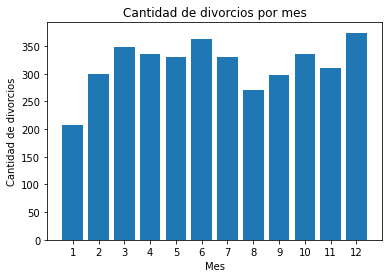

In [30]:
meses_divorcios = divorcios['fecha_divorcio'].apply(lambda row: row.month).value_counts().sort_index()
plt.bar(x=meses_divorcios.index, height=meses_divorcios.array)
plt.xticks(meses_divorcios.index)
plt.xlabel("Mes")
plt.ylabel("Cantidad de divorcios")
plt.title("Cantidad de divorcios por mes")
plt.show()

In [31]:
divorcios.head()

,fecha_divorcio,tipo_divorcio,edad_h,ocupacion_h,edad_m,ocupacion_m,fecha_matrimonio,nivel_educacion_h,estatus_empleo_h,nivel_educacion_m,estatus_empleo_m,duracion_matrimonio,numero_hijos,viven_juntos,diferencia_edades
0,2006-06-09,Necesario,30.0,PINTOR,22.0,EMPLEADA,2000-06-26,SECUNDARIA,OBRERO,SECUNDARIA,EMPLEADO,5.0,1.0,0,8.0
4,2006-02-01,Necesario,30.0,MEDICO,27.0,AMA DE CASA,1998-11-14,PROFESIONAL,EMPLEADO,PREPARATORIA,NO TRABAJA,7.0,2.0,0,3.0
6,2007-02-01,Necesario,36.0,EMPLEADO,35.0,LABORES DOMESTICAS,1991-08-16,PROFESIONAL,EMPLEADO,PROFESIONAL,NO TRABAJA,15.0,2.0,0,1.0
7,2007-02-01,Necesario,31.0,LICENCIADO,32.0,LICENCIADA,1999-09-17,PROFESIONAL,EMPLEADO,PROFESIONAL,EMPLEADO,7.0,1.0,0,1.0
8,2008-02-01,Voluntario,31.0,COMERCIANTE,28.0,EMPLEADA,2006-06-03,PROFESIONAL,EMPLEADO,PROFESIONAL,NO TRABAJA,1.0,0.0,0,3.0


## ¿Que nivel de educación predomina en los divorciados?

In [32]:
def horizontal_plot(column, title, y_label, x_label):
    column_serie = column.value_counts()
    categorias = column_serie.index
    valores = column_serie.array

    plt.figure(figsize=(12, 4))
    plt.barh(categorias, valores, align='center')
    plt.title(title, fontsize=16)
    plt.ylabel(y_label, fontsize=14)
    plt.xlabel(x_label, fontsize=14)
    for index, data in enumerate(valores):
        if data != 0:
            plt.text(x = data+10, y = index-0.10, s=f'{data}')
    plt.show()

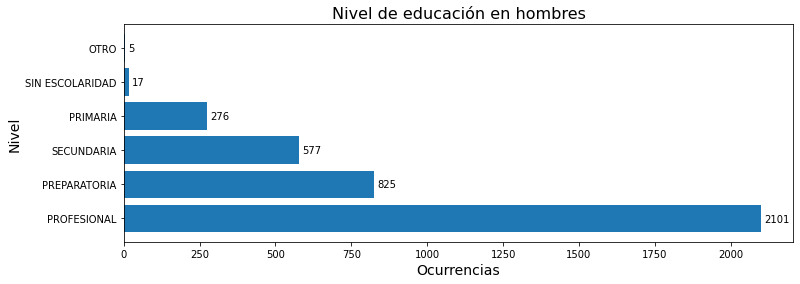

In [33]:
horizontal_plot(divorcios["nivel_educacion_h"], "Nivel de educación en hombres", "Nivel", "Ocurrencias")

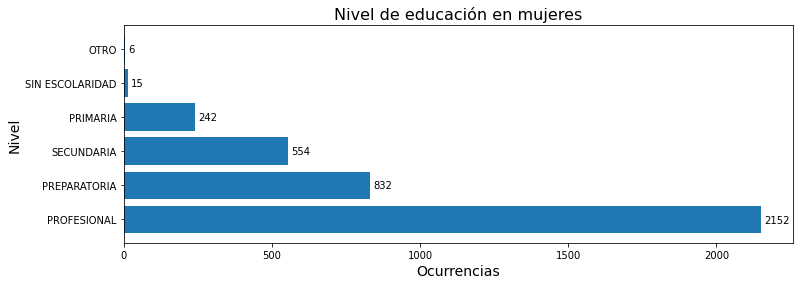

In [34]:
horizontal_plot(divorcios["nivel_educacion_m"], "Nivel de educación en mujeres", "Nivel", "Ocurrencias")

## ¿En qué edades de la población se concentra la mayor cantidad de divorcios?

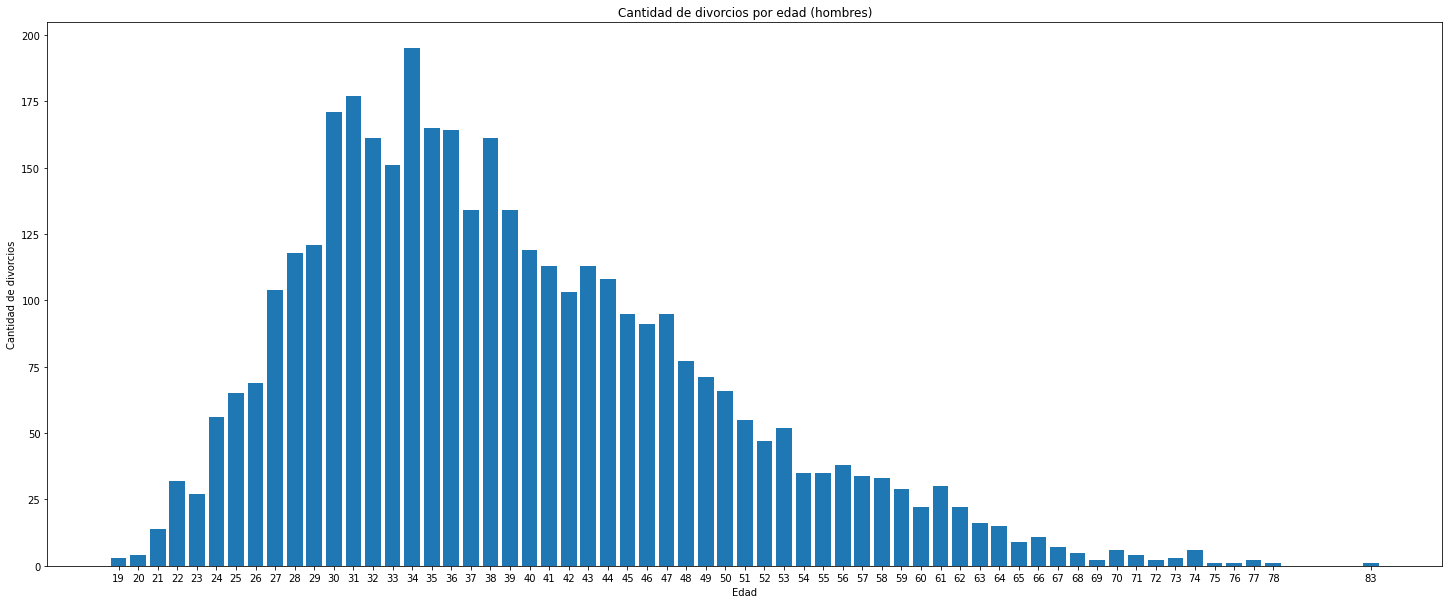

In [35]:
edad_hombres = divorcios["edad_h"].value_counts().sort_index()

plt.figure(figsize=(25,10))
plt.bar(x=edad_hombres.index, height=edad_hombres.array)
plt.xticks(edad_hombres.index)
plt.xlabel("Edad")
plt.ylabel("Cantidad de divorcios")
plt.title("Cantidad de divorcios por edad (hombres)")
plt.show()

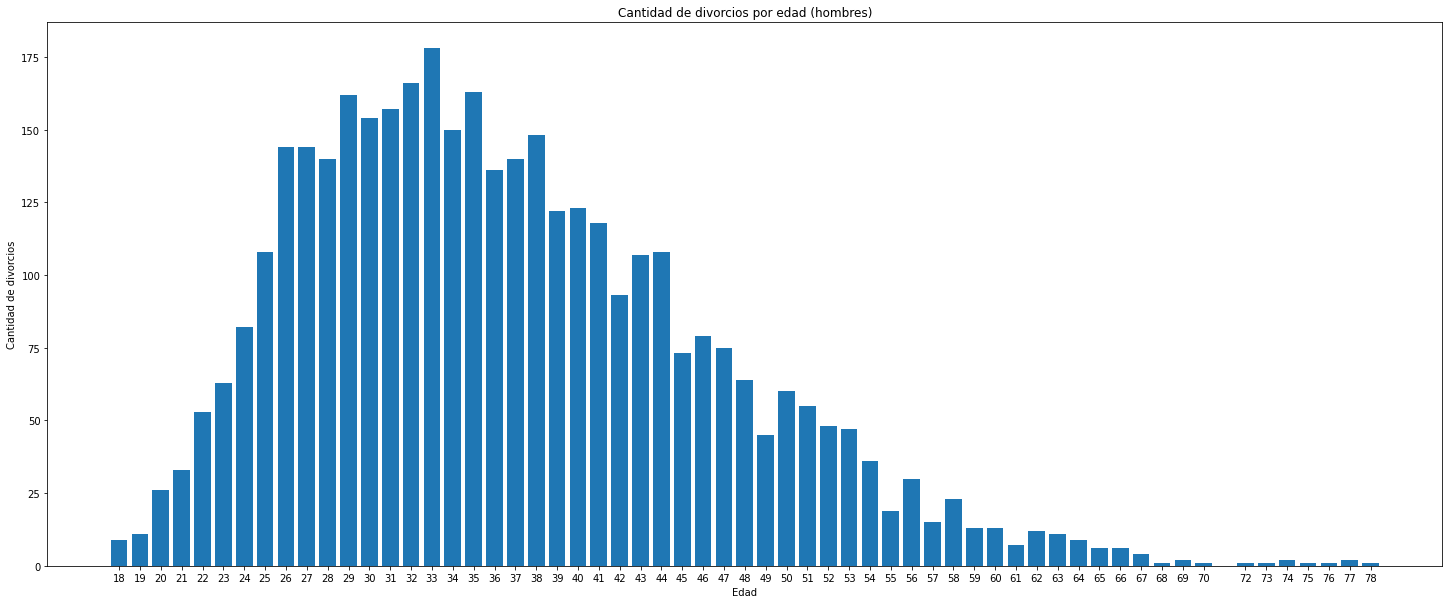

In [36]:
edad_mujeres = divorcios["edad_m"].value_counts().sort_index()

plt.figure(figsize=(25,10))
plt.bar(x=edad_mujeres.index, height=edad_mujeres.array)
plt.xticks(edad_mujeres.index)
plt.xlabel("Edad")
plt.ylabel("Cantidad de divorcios")
plt.title("Cantidad de divorcios por edad (hombres)")
plt.show()

Observando la distribución de edades en los casos de divorcio, notamos que la mayoría se concentra alrededor de los 30-35 años.

## ¿Cómo influye la diferencia de edad en una pareja?

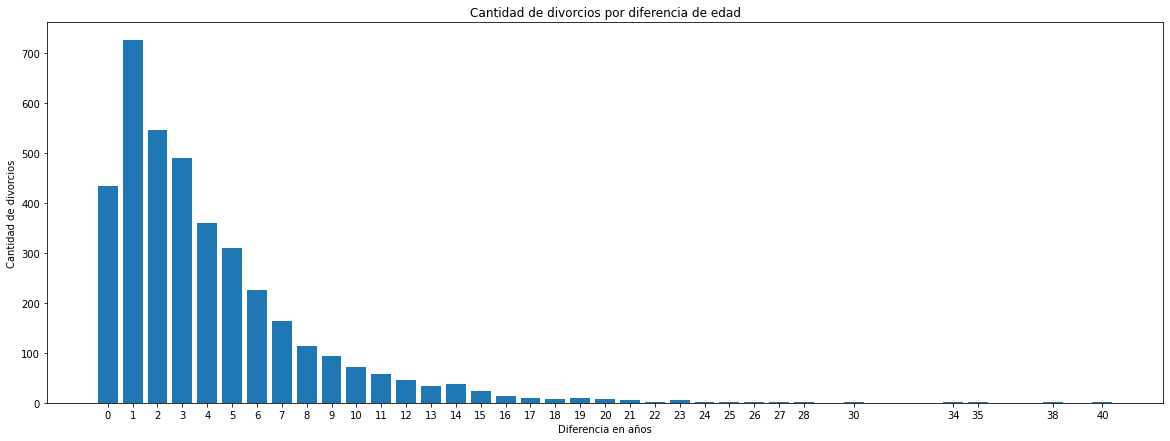

In [197]:
diferencia_edades = divorcios["diferencia_edades"].value_counts().sort_index()

plt.figure(figsize=(20,7))
plt.bar(x=diferencia_edades.index, height=diferencia_edades.array)
plt.xticks(diferencia_edades.index)
plt.xlabel("Diferencia en años")
plt.ylabel("Cantidad de divorcios")
plt.title("Cantidad de divorcios por diferencia de edad")
plt.show()

In [38]:
divorcios[divorcios["diferencia_edades"] == 1].shape[0] / divorcios.shape[0]

0.1907392791370692

Según los datos, suele haber más divorcios de parejas que tienen una diferencia de edad más baja. Siendo La diferencia de edad de un año la que predomina más, con un 19%

## Número de hijos

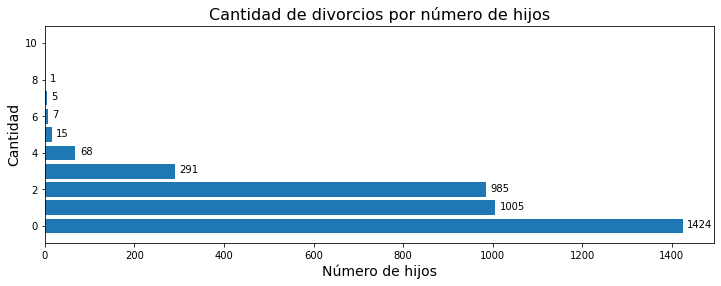

In [39]:
divorcios["numero_hijos"].value_counts()
horizontal_plot(divorcios["numero_hijos"], "Cantidad de divorcios por número de hijos", "Cantidad", "Número de hijos")

Según los datos, las parejas con un menor número de hijos podrían ser más propensas a divorciarse.

## ¿Viven juntos?

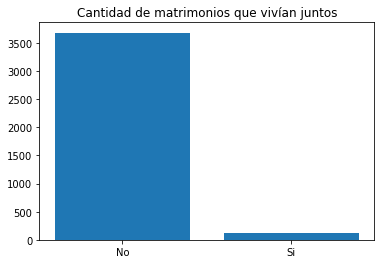

In [40]:
cantidad_viven_juntos = divorcios["viven_juntos"].value_counts()
etiquetas = ["No", "Si"]
plt.bar(etiquetas, cantidad_viven_juntos.values)
plt.title("Cantidad de matrimonios que vivían juntos")
plt.show()

## Las 10 profesiones con más divorcios

Exploremos un poco las profesiones que más ocurrencias tienen cuando de divorcios se trata.

In [41]:
# Algunas muestras en esta columna están etiquetadas como EMPLEADO y otras como EMPLEADA, asumiremos que estas se refieren a lo mismo
divorcios["ocupacion_m"] = divorcios["ocupacion_m"].apply(lambda row: "EMPLEADA" if row == "EMPLEADO" else row)

In [42]:
prof_mas_divorcios_h = divorcios["ocupacion_h"].value_counts()[1:10]
prof_mas_divorcios_m = divorcios["ocupacion_m"].value_counts()[1:10]

In [43]:
prof_mas_divorcios_m

AMA DE CASA           459
LABORES DOMESTICAS    286
MAESTRA               191
COMERCIANTE           152
PROFESORA             125
ESTUDIANTE            114
EDUCADORA              58
DOCENTE                49
SECRETARIA             43
Name: ocupacion_m, dtype: int64

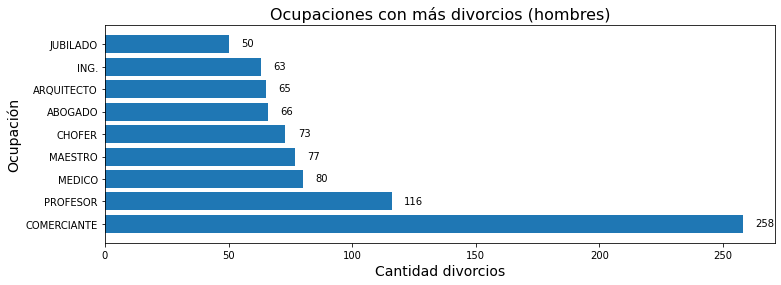

In [44]:
categorias = prof_mas_divorcios_h.index
valores = prof_mas_divorcios_h.array

plt.figure(figsize=(12, 4))
plt.barh(categorias, valores, align='center')
plt.title("Ocupaciones con más divorcios (hombres)", fontsize=16)
plt.ylabel("Ocupación", fontsize=14)
plt.xlabel("Cantidad divorcios", fontsize=14)
for index, data in enumerate(valores):
    if data != 0:
        plt.text(x = data+5, y = index-0.10, s=f'{data}')
plt.show()

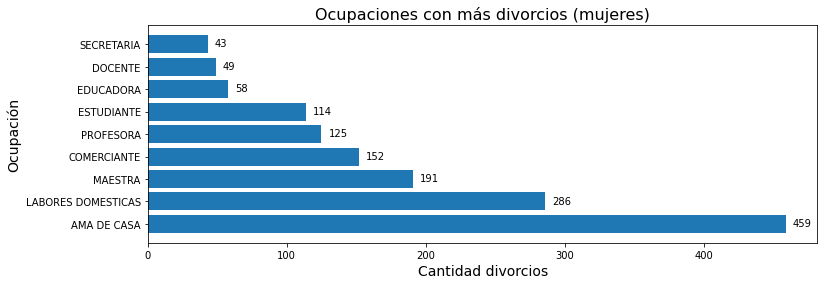

In [45]:
categorias = prof_mas_divorcios_m.index
valores = prof_mas_divorcios_m.array

plt.figure(figsize=(12, 4))
plt.barh(categorias, valores, align='center')
plt.title("Ocupaciones con más divorcios (mujeres)", fontsize=16)
plt.ylabel("Ocupación", fontsize=14)
plt.xlabel("Cantidad divorcios", fontsize=14)
for index, data in enumerate(valores):
    if data != 0:
        plt.text(x = data+5, y = index-0.10, s=f'{data}')
plt.show()

In [46]:
divorcios.head()

,fecha_divorcio,tipo_divorcio,edad_h,ocupacion_h,edad_m,ocupacion_m,fecha_matrimonio,nivel_educacion_h,estatus_empleo_h,nivel_educacion_m,estatus_empleo_m,duracion_matrimonio,numero_hijos,viven_juntos,diferencia_edades
0,2006-06-09,Necesario,30.0,PINTOR,22.0,EMPLEADA,2000-06-26,SECUNDARIA,OBRERO,SECUNDARIA,EMPLEADO,5.0,1.0,0,8.0
4,2006-02-01,Necesario,30.0,MEDICO,27.0,AMA DE CASA,1998-11-14,PROFESIONAL,EMPLEADO,PREPARATORIA,NO TRABAJA,7.0,2.0,0,3.0
6,2007-02-01,Necesario,36.0,EMPLEADO,35.0,LABORES DOMESTICAS,1991-08-16,PROFESIONAL,EMPLEADO,PROFESIONAL,NO TRABAJA,15.0,2.0,0,1.0
7,2007-02-01,Necesario,31.0,LICENCIADO,32.0,LICENCIADA,1999-09-17,PROFESIONAL,EMPLEADO,PROFESIONAL,EMPLEADO,7.0,1.0,0,1.0
8,2008-02-01,Voluntario,31.0,COMERCIANTE,28.0,EMPLEADA,2006-06-03,PROFESIONAL,EMPLEADO,PROFESIONAL,NO TRABAJA,1.0,0.0,0,3.0


# Preprocesamiento de los datos para entrenar un modelo predictivo

## Convirtiendo variables categóricas a numéricas
Primero crearemos una copia del datframe para procesarla

In [47]:
divorcios_procesada = divorcios.copy()

### Variables binarias
#### Tipo de divorcio

In [48]:
print(divorcios['tipo_divorcio'].unique())

['Necesario' 'Voluntario']


In [49]:
le = LabelEncoder()
divorcios_procesada['voluntario'] = le.fit_transform(divorcios_procesada['tipo_divorcio'])

In [50]:
# Ahora ya tenemos nuestra variable númerica y binaria
divorcios_procesada[['tipo_divorcio', 'voluntario']].head()

,tipo_divorcio,voluntario
0,Necesario,0
4,Necesario,0
6,Necesario,0
7,Necesario,0
8,Voluntario,1


In [51]:
divorcios_procesada.head()

,fecha_divorcio,tipo_divorcio,edad_h,ocupacion_h,edad_m,ocupacion_m,fecha_matrimonio,nivel_educacion_h,estatus_empleo_h,nivel_educacion_m,estatus_empleo_m,duracion_matrimonio,numero_hijos,viven_juntos,diferencia_edades,voluntario
0,2006-06-09,Necesario,30.0,PINTOR,22.0,EMPLEADA,2000-06-26,SECUNDARIA,OBRERO,SECUNDARIA,EMPLEADO,5.0,1.0,0,8.0,0
4,2006-02-01,Necesario,30.0,MEDICO,27.0,AMA DE CASA,1998-11-14,PROFESIONAL,EMPLEADO,PREPARATORIA,NO TRABAJA,7.0,2.0,0,3.0,0
6,2007-02-01,Necesario,36.0,EMPLEADO,35.0,LABORES DOMESTICAS,1991-08-16,PROFESIONAL,EMPLEADO,PROFESIONAL,NO TRABAJA,15.0,2.0,0,1.0,0
7,2007-02-01,Necesario,31.0,LICENCIADO,32.0,LICENCIADA,1999-09-17,PROFESIONAL,EMPLEADO,PROFESIONAL,EMPLEADO,7.0,1.0,0,1.0,0
8,2008-02-01,Voluntario,31.0,COMERCIANTE,28.0,EMPLEADA,2006-06-03,PROFESIONAL,EMPLEADO,PROFESIONAL,NO TRABAJA,1.0,0.0,0,3.0,1


### Variables con más de dos categorías
#### Nivel de educación

In [52]:
print(divorcios['nivel_educacion_h'].unique())
print(divorcios['nivel_educacion_m'].unique())

['SECUNDARIA' 'PROFESIONAL' 'PREPARATORIA' 'PRIMARIA' 'OTRO'
 'SIN ESCOLARIDAD']
['SECUNDARIA' 'PREPARATORIA' 'PROFESIONAL' 'OTRO' 'PRIMARIA'
 'SIN ESCOLARIDAD']


In [53]:
# Obtendremos nuevas columnas con ayuda de la función get_dummies
NE_h_dummies = pd.get_dummies(divorcios_procesada['nivel_educacion_h'], prefix='NE_h')
NE_m_dummies = pd.get_dummies(divorcios_procesada['nivel_educacion_m'], prefix='NE_m')

In [54]:
NE_h_dummies.head()

,NE_h_OTRO,NE_h_PREPARATORIA,NE_h_PRIMARIA,NE_h_PROFESIONAL,NE_h_SECUNDARIA,NE_h_SIN ESCOLARIDAD
0,0,0,0,0,1,0
4,0,0,0,1,0,0
6,0,0,0,1,0,0
7,0,0,0,1,0,0
8,0,0,0,1,0,0


In [55]:
divorcios_procesada = pd.concat([divorcios_procesada, NE_h_dummies, NE_m_dummies], axis=1)

In [56]:
divorcios_procesada.head()

,fecha_divorcio,tipo_divorcio,edad_h,ocupacion_h,edad_m,ocupacion_m,fecha_matrimonio,nivel_educacion_h,estatus_empleo_h,nivel_educacion_m,estatus_empleo_m,duracion_matrimonio,numero_hijos,viven_juntos,diferencia_edades,voluntario,NE_h_OTRO,NE_h_PREPARATORIA,NE_h_PRIMARIA,NE_h_PROFESIONAL,NE_h_SECUNDARIA,NE_h_SIN ESCOLARIDAD,NE_m_OTRO,NE_m_PREPARATORIA,NE_m_PRIMARIA,NE_m_PROFESIONAL,NE_m_SECUNDARIA,NE_m_SIN ESCOLARIDAD
0,2006-06-09,Necesario,30.0,PINTOR,22.0,EMPLEADA,2000-06-26,SECUNDARIA,OBRERO,SECUNDARIA,EMPLEADO,5.0,1.0,0,8.0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,2006-02-01,Necesario,30.0,MEDICO,27.0,AMA DE CASA,1998-11-14,PROFESIONAL,EMPLEADO,PREPARATORIA,NO TRABAJA,7.0,2.0,0,3.0,0,0,0,0,1,0,0,0,1,0,0,0,0
6,2007-02-01,Necesario,36.0,EMPLEADO,35.0,LABORES DOMESTICAS,1991-08-16,PROFESIONAL,EMPLEADO,PROFESIONAL,NO TRABAJA,15.0,2.0,0,1.0,0,0,0,0,1,0,0,0,0,0,1,0,0
7,2007-02-01,Necesario,31.0,LICENCIADO,32.0,LICENCIADA,1999-09-17,PROFESIONAL,EMPLEADO,PROFESIONAL,EMPLEADO,7.0,1.0,0,1.0,0,0,0,0,1,0,0,0,0,0,1,0,0
8,2008-02-01,Voluntario,31.0,COMERCIANTE,28.0,EMPLEADA,2006-06-03,PROFESIONAL,EMPLEADO,PROFESIONAL,NO TRABAJA,1.0,0.0,0,3.0,1,0,0,0,1,0,0,0,0,0,1,0,0


#### Ocupación

In [57]:
print("Valores únicos para ocupaciones en hombres:", len(divorcios['ocupacion_h'].unique()))
print("Valores únicos para ocupaciones en mujeres:", len(divorcios['ocupacion_m'].unique()))

Valores únicos para ocupaciones en hombres: 207
Valores únicos para ocupaciones en mujeres: 143


No quisieramos aumentar tanto la dimensionalidad de nuestros datos, así que tomaremos otra medida para no incluir mas de 207 columnas.  
Así que mejor tomaremos la columna estado_empleo, que es menos específica y brinda información similar.

In [58]:
print("Valores únicos para el estatus empleo en hombres:", len(divorcios['estatus_empleo_h'].unique()))
print("Valores únicos para el estatus empleo en mujeres:", len(divorcios['estatus_empleo_m'].unique()))

Valores únicos para el estatus empleo en hombres: 10
Valores únicos para el estatus empleo en mujeres: 10


In [59]:
empleo_h_dummies = pd.get_dummies(divorcios_procesada['estatus_empleo_h'], prefix='empleo_h')
empleo_m_dummies = pd.get_dummies(divorcios_procesada['estatus_empleo_m'], prefix='empleo_m')
empleo_h_dummies.head()

,empleo_h_EMPLEADO,empleo_h_ESTABLECIMIENTO,empleo_h_JORNALERO O PEON,empleo_h_MIEMBRO DE COOPERATIVA,empleo_h_NO TRABAJA,empleo_h_OBRERO,empleo_h_PATRON O EMPRESARIO,empleo_h_TRABAJA EN SU VIVIENDA,empleo_h_TRABAJADOR NO REMUNERADO,empleo_h_TRABAJADOR POR SU PROPIA CUENTA O EN VIA PUBLICA
0,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0


In [60]:
divorcios_procesada = pd.concat([divorcios_procesada, empleo_h_dummies, empleo_m_dummies], axis=1)
divorcios_procesada.head()

,fecha_divorcio,tipo_divorcio,edad_h,ocupacion_h,edad_m,ocupacion_m,fecha_matrimonio,nivel_educacion_h,estatus_empleo_h,nivel_educacion_m,estatus_empleo_m,duracion_matrimonio,numero_hijos,viven_juntos,diferencia_edades,voluntario,NE_h_OTRO,NE_h_PREPARATORIA,NE_h_PRIMARIA,NE_h_PROFESIONAL,NE_h_SECUNDARIA,NE_h_SIN ESCOLARIDAD,NE_m_OTRO,NE_m_PREPARATORIA,NE_m_PRIMARIA,NE_m_PROFESIONAL,NE_m_SECUNDARIA,NE_m_SIN ESCOLARIDAD,empleo_h_EMPLEADO,empleo_h_ESTABLECIMIENTO,empleo_h_JORNALERO O PEON,empleo_h_MIEMBRO DE COOPERATIVA,empleo_h_NO TRABAJA,empleo_h_OBRERO,empleo_h_PATRON O EMPRESARIO,empleo_h_TRABAJA EN SU VIVIENDA,empleo_h_TRABAJADOR NO REMUNERADO,empleo_h_TRABAJADOR POR SU PROPIA CUENTA O EN VIA PUBLICA,empleo_m_EMPLEADO,empleo_m_ESTABLECIMIENTO,empleo_m_JORNALERO O PEON,empleo_m_MIEMBRO DE COOPERATIVA,empleo_m_NO TRABAJA,empleo_m_OBRERO,empleo_m_PATRON O EMPRESARIO,empleo_m_TRABAJA EN SU VIVIENDA,empleo_m_TRABAJADOR NO REMUNERADO,empleo_m_TRABAJADOR POR CUENTA PROPIA EN VIA PUBLICA
0,2006-06-09,Necesario,30.0,PINTOR,22.0,EMPLEADA,2000-06-26,SECUNDARIA,OBRERO,SECUNDARIA,EMPLEADO,5.0,1.0,0,8.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2006-02-01,Necesario,30.0,MEDICO,27.0,AMA DE CASA,1998-11-14,PROFESIONAL,EMPLEADO,PREPARATORIA,NO TRABAJA,7.0,2.0,0,3.0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6,2007-02-01,Necesario,36.0,EMPLEADO,35.0,LABORES DOMESTICAS,1991-08-16,PROFESIONAL,EMPLEADO,PROFESIONAL,NO TRABAJA,15.0,2.0,0,1.0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
7,2007-02-01,Necesario,31.0,LICENCIADO,32.0,LICENCIADA,1999-09-17,PROFESIONAL,EMPLEADO,PROFESIONAL,EMPLEADO,7.0,1.0,0,1.0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
8,2008-02-01,Voluntario,31.0,COMERCIANTE,28.0,EMPLEADA,2006-06-03,PROFESIONAL,EMPLEADO,PROFESIONAL,NO TRABAJA,1.0,0.0,0,3.0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


## Convirtiendo las variables de fecha a numéricas

In [61]:
# Estas columnas se eliminarán después, ya que en un caso real, no podrás saber cual es la fecha de divorcio de una pareja
# divorcios_procesada['anio_divorcio'] = divorcios_procesada['Divorce_date'].dt.year
# divorcios_procesada['mes_divorcio'] = divorcios_procesada['Divorce_date'].dt.month

divorcios_procesada['anio_matrimonio'] = divorcios_procesada['fecha_matrimonio'].dt.year
divorcios_procesada['mes_matrimonio'] = divorcios_procesada['fecha_matrimonio'].dt.month

## Eliminando las columnas que ahora resultan redundantes o que evitan tener escenarios realistas
Como por ejemplo, las columnas referentes a la fecha del divorcio y al tipo de divorcio.

In [62]:
divorcios_procesada = divorcios_procesada.drop(columns=['fecha_divorcio', 'nivel_educacion_h', 'nivel_educacion_m',
                                                        'estatus_empleo_h', 'estatus_empleo_m', 'ocupacion_h', 'ocupacion_m',
                                                        'fecha_matrimonio', 'tipo_divorcio', 'voluntario'])
print(divorcios_procesada.columns)

Index(['edad_h', 'edad_m', 'duracion_matrimonio', 'numero_hijos',
       'viven_juntos', 'diferencia_edades', 'NE_h_OTRO', 'NE_h_PREPARATORIA',
       'NE_h_PRIMARIA', 'NE_h_PROFESIONAL', 'NE_h_SECUNDARIA',
       'NE_h_SIN ESCOLARIDAD', 'NE_m_OTRO', 'NE_m_PREPARATORIA',
       'NE_m_PRIMARIA', 'NE_m_PROFESIONAL', 'NE_m_SECUNDARIA',
       'NE_m_SIN ESCOLARIDAD', 'empleo_h_EMPLEADO', 'empleo_h_ESTABLECIMIENTO',
       'empleo_h_JORNALERO O PEON', 'empleo_h_MIEMBRO DE COOPERATIVA',
       'empleo_h_NO TRABAJA', 'empleo_h_OBRERO',
       'empleo_h_PATRON O EMPRESARIO', 'empleo_h_TRABAJA EN SU VIVIENDA',
       'empleo_h_TRABAJADOR NO REMUNERADO',
       'empleo_h_TRABAJADOR POR SU PROPIA CUENTA O EN VIA PUBLICA',
       'empleo_m_EMPLEADO', 'empleo_m_ESTABLECIMIENTO',
       'empleo_m_JORNALERO O PEON', 'empleo_m_MIEMBRO DE COOPERATIVA',
       'empleo_m_NO TRABAJA', 'empleo_m_OBRERO',
       'empleo_m_PATRON O EMPRESARIO', 'empleo_m_TRABAJA EN SU VIVIENDA',
       'empleo_m_TRABAJADOR N

## Así queda nuestro dataframe después de procesar las variables categóricas y de fechas

In [63]:
# Antes
divorcios.head()

,fecha_divorcio,tipo_divorcio,edad_h,ocupacion_h,edad_m,ocupacion_m,fecha_matrimonio,nivel_educacion_h,estatus_empleo_h,nivel_educacion_m,estatus_empleo_m,duracion_matrimonio,numero_hijos,viven_juntos,diferencia_edades
0,2006-06-09,Necesario,30.0,PINTOR,22.0,EMPLEADA,2000-06-26,SECUNDARIA,OBRERO,SECUNDARIA,EMPLEADO,5.0,1.0,0,8.0
4,2006-02-01,Necesario,30.0,MEDICO,27.0,AMA DE CASA,1998-11-14,PROFESIONAL,EMPLEADO,PREPARATORIA,NO TRABAJA,7.0,2.0,0,3.0
6,2007-02-01,Necesario,36.0,EMPLEADO,35.0,LABORES DOMESTICAS,1991-08-16,PROFESIONAL,EMPLEADO,PROFESIONAL,NO TRABAJA,15.0,2.0,0,1.0
7,2007-02-01,Necesario,31.0,LICENCIADO,32.0,LICENCIADA,1999-09-17,PROFESIONAL,EMPLEADO,PROFESIONAL,EMPLEADO,7.0,1.0,0,1.0
8,2008-02-01,Voluntario,31.0,COMERCIANTE,28.0,EMPLEADA,2006-06-03,PROFESIONAL,EMPLEADO,PROFESIONAL,NO TRABAJA,1.0,0.0,0,3.0


In [64]:
# Después
divorcios_procesada.head()

,edad_h,edad_m,duracion_matrimonio,numero_hijos,viven_juntos,diferencia_edades,NE_h_OTRO,NE_h_PREPARATORIA,NE_h_PRIMARIA,NE_h_PROFESIONAL,NE_h_SECUNDARIA,NE_h_SIN ESCOLARIDAD,NE_m_OTRO,NE_m_PREPARATORIA,NE_m_PRIMARIA,NE_m_PROFESIONAL,NE_m_SECUNDARIA,NE_m_SIN ESCOLARIDAD,empleo_h_EMPLEADO,empleo_h_ESTABLECIMIENTO,empleo_h_JORNALERO O PEON,empleo_h_MIEMBRO DE COOPERATIVA,empleo_h_NO TRABAJA,empleo_h_OBRERO,empleo_h_PATRON O EMPRESARIO,empleo_h_TRABAJA EN SU VIVIENDA,empleo_h_TRABAJADOR NO REMUNERADO,empleo_h_TRABAJADOR POR SU PROPIA CUENTA O EN VIA PUBLICA,empleo_m_EMPLEADO,empleo_m_ESTABLECIMIENTO,empleo_m_JORNALERO O PEON,empleo_m_MIEMBRO DE COOPERATIVA,empleo_m_NO TRABAJA,empleo_m_OBRERO,empleo_m_PATRON O EMPRESARIO,empleo_m_TRABAJA EN SU VIVIENDA,empleo_m_TRABAJADOR NO REMUNERADO,empleo_m_TRABAJADOR POR CUENTA PROPIA EN VIA PUBLICA,anio_matrimonio,mes_matrimonio
0,30.0,22.0,5.0,1.0,0,8.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2000,6
4,30.0,27.0,7.0,2.0,0,3.0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1998,11
6,36.0,35.0,15.0,2.0,0,1.0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1991,8
7,31.0,32.0,7.0,1.0,0,1.0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1999,9
8,31.0,28.0,1.0,0.0,0,3.0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2006,6


In [65]:
divorcios_procesada.columns

Index(['edad_h', 'edad_m', 'duracion_matrimonio', 'numero_hijos',
       'viven_juntos', 'diferencia_edades', 'NE_h_OTRO', 'NE_h_PREPARATORIA',
       'NE_h_PRIMARIA', 'NE_h_PROFESIONAL', 'NE_h_SECUNDARIA',
       'NE_h_SIN ESCOLARIDAD', 'NE_m_OTRO', 'NE_m_PREPARATORIA',
       'NE_m_PRIMARIA', 'NE_m_PROFESIONAL', 'NE_m_SECUNDARIA',
       'NE_m_SIN ESCOLARIDAD', 'empleo_h_EMPLEADO', 'empleo_h_ESTABLECIMIENTO',
       'empleo_h_JORNALERO O PEON', 'empleo_h_MIEMBRO DE COOPERATIVA',
       'empleo_h_NO TRABAJA', 'empleo_h_OBRERO',
       'empleo_h_PATRON O EMPRESARIO', 'empleo_h_TRABAJA EN SU VIVIENDA',
       'empleo_h_TRABAJADOR NO REMUNERADO',
       'empleo_h_TRABAJADOR POR SU PROPIA CUENTA O EN VIA PUBLICA',
       'empleo_m_EMPLEADO', 'empleo_m_ESTABLECIMIENTO',
       'empleo_m_JORNALERO O PEON', 'empleo_m_MIEMBRO DE COOPERATIVA',
       'empleo_m_NO TRABAJA', 'empleo_m_OBRERO',
       'empleo_m_PATRON O EMPRESARIO', 'empleo_m_TRABAJA EN SU VIVIENDA',
       'empleo_m_TRABAJADOR N

In [66]:
print(divorcios.shape)
print(divorcios_procesada.shape)

(3801, 15)
(3801, 40)


## Dividiendo los datos en set de entrenamiento y de prueba

### Primero separamos nuestra variable objetivo de demás
En este caso, la variable objetivo (y) será la duración de un matrimonio, considerando un conjunto de factores (X).

In [67]:
X = divorcios_procesada.drop(columns=['duracion_matrimonio'])
y = divorcios_procesada['duracion_matrimonio']

In [68]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)

print(X_train.shape)
print(X_test.shape)

(3040, 39)
(761, 39)


Contamos con **3040** muestras de entrenamiento y **761** muestras para prueba (80% y 20% respectivamente).

## Normalizando y escalando los datos

In [69]:
# from sklearn.preprocessing import Normalizer, MinMaxScaler
# from sklearn.pipeline import Pipeline

# # Crear el pipeline
# pipeline = Pipeline( [('normalizer', Normalizer()), ('scaler', MinMaxScaler())] )

# # Pasamos los datos por el pipeline para que ajuste sus parámetros
# pipeline.fit(X_train)

Pipeline(steps=[('normalizer', Normalizer()), ('scaler', MinMaxScaler())])

In [70]:
# Aplicamos una transformación a los datos con los parámetros ajustados por el pipeline
# X_train_transformed = pipeline.transform(X_train)
# X_test_transformed = pipeline.transform(X_test)

## Entrenamiento

Para el caso de este set de datos, más que intentar predecir variables, nos interesa analizar las características y los patrones que tienen las parejas que se divorcian. Pero para muestra de la calidad de los datos, intentaremos predecir la duración en años de un matrimonio que sabemos que se divorciará.
Para ello utilizaremos un modelo ensemble, Random Forest Regressor, que utiliza varios árboles de decisión para hacer una predicción precisa.

In [71]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [137]:
rfr = RandomForestRegressor(random_state=11)
rfr.fit(X_train, y_train)

RandomForestRegressor(random_state=11)

In [138]:
y_pred_rfr = rfr.predict(X_test)
mae_rfr = MAE(y_test, y_pred_rfr)
print(f'Random Forest Regressor score: {mae_rfr}')

Random Forest Regressor score: 2.148740692071835


In [139]:
num_muestras = 10
print(y_pred_rfr[:num_muestras])
print(list(y_test.iloc[:num_muestras].array))

[ 6.51 14.41  3.49 35.51 24.29  4.55 35.58  2.23 15.51 10.39]
[8.0, 21.0, 4.0, 37.0, 21.0, 4.0, 36.0, 2.0, 27.0, 17.0]


## Resultados de las predicciones
Nuestro modelo es capaz de predecir la duración de un matrimonio con un error absoluto de 2 años. Lo que es bastante aceptable.

## Guardando y probando nuestro modelo

In [187]:
import pickle

# Guardando el modelo al disco
filename = 'divorcios_modelo.sav'
pickle.dump(rfr, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9184505207722536


In [93]:
divorcios_procesada.head(2)

,edad_h,edad_m,duracion_matrimonio,numero_hijos,viven_juntos,diferencia_edades,NE_h_OTRO,NE_h_PREPARATORIA,NE_h_PRIMARIA,NE_h_PROFESIONAL,NE_h_SECUNDARIA,NE_h_SIN ESCOLARIDAD,NE_m_OTRO,NE_m_PREPARATORIA,NE_m_PRIMARIA,NE_m_PROFESIONAL,NE_m_SECUNDARIA,NE_m_SIN ESCOLARIDAD,empleo_h_EMPLEADO,empleo_h_ESTABLECIMIENTO,empleo_h_JORNALERO O PEON,empleo_h_MIEMBRO DE COOPERATIVA,empleo_h_NO TRABAJA,empleo_h_OBRERO,empleo_h_PATRON O EMPRESARIO,empleo_h_TRABAJA EN SU VIVIENDA,empleo_h_TRABAJADOR NO REMUNERADO,empleo_h_TRABAJADOR POR SU PROPIA CUENTA O EN VIA PUBLICA,empleo_m_EMPLEADO,empleo_m_ESTABLECIMIENTO,empleo_m_JORNALERO O PEON,empleo_m_MIEMBRO DE COOPERATIVA,empleo_m_NO TRABAJA,empleo_m_OBRERO,empleo_m_PATRON O EMPRESARIO,empleo_m_TRABAJA EN SU VIVIENDA,empleo_m_TRABAJADOR NO REMUNERADO,empleo_m_TRABAJADOR POR CUENTA PROPIA EN VIA PUBLICA,anio_matrimonio,mes_matrimonio
0,30.0,22.0,5.0,1.0,0,8.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2000,6
4,30.0,27.0,7.0,2.0,0,3.0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1998,11


In [92]:
divorcios_procesada.columns

Index(['edad_h', 'edad_m', 'duracion_matrimonio', 'numero_hijos',
       'viven_juntos', 'diferencia_edades', 'NE_h_OTRO', 'NE_h_PREPARATORIA',
       'NE_h_PRIMARIA', 'NE_h_PROFESIONAL', 'NE_h_SECUNDARIA',
       'NE_h_SIN ESCOLARIDAD', 'NE_m_OTRO', 'NE_m_PREPARATORIA',
       'NE_m_PRIMARIA', 'NE_m_PROFESIONAL', 'NE_m_SECUNDARIA',
       'NE_m_SIN ESCOLARIDAD', 'empleo_h_EMPLEADO', 'empleo_h_ESTABLECIMIENTO',
       'empleo_h_JORNALERO O PEON', 'empleo_h_MIEMBRO DE COOPERATIVA',
       'empleo_h_NO TRABAJA', 'empleo_h_OBRERO',
       'empleo_h_PATRON O EMPRESARIO', 'empleo_h_TRABAJA EN SU VIVIENDA',
       'empleo_h_TRABAJADOR NO REMUNERADO',
       'empleo_h_TRABAJADOR POR SU PROPIA CUENTA O EN VIA PUBLICA',
       'empleo_m_EMPLEADO', 'empleo_m_ESTABLECIMIENTO',
       'empleo_m_JORNALERO O PEON', 'empleo_m_MIEMBRO DE COOPERATIVA',
       'empleo_m_NO TRABAJA', 'empleo_m_OBRERO',
       'empleo_m_PATRON O EMPRESARIO', 'empleo_m_TRABAJA EN SU VIVIENDA',
       'empleo_m_TRABAJADOR N

In [176]:
edad_h = 35
edad_m = 30
numero_hijos = 3
viven_juntos = 1
nivel_educ_h = "PROFESIONAL"
nivel_educ_m = "PROFESIONAL"
estatus_empleo_h = "PATRON O EMPRESARIO"
estatus_empleo_m = "EMPLEADO"
anio_matrimonio = 1998
mes_matrimonio = 10

lista_datos = [edad_h, edad_m, numero_hijos, viven_juntos, nivel_educ_h, nivel_educ_m, estatus_empleo_h, estatus_empleo_m, anio_matrimonio, mes_matrimonio]

In [188]:
def predecir_anios(modelo, edad_h, edad_m, numero_hijos, viven_juntos, nivel_educ_h, nivel_educ_m, estatus_empleo_h, estatus_empleo_m, anio_matrimonio, mes_matrimonio):
    data = {
        "edad_h" : edad_h,
        "edad_m" : edad_m,
        "numero_hijos" : numero_hijos,
        "viven_juntos" : viven_juntos,
        "diferencia_edades" : abs(edad_h - edad_m) ,

        "NE_h_OTRO" : 1 if nivel_educ_h.upper() == "OTRO" else 0 ,
        "NE_h_PREPARATORIA" : 1 if nivel_educ_h.upper() == "PREPARATORIA" else 0 ,
        "NE_h_PRIMARIA" : 1 if nivel_educ_h.upper() == "PRIMARIA" else 0 ,
        "NE_h_PROFESIONAL" : 1 if nivel_educ_h.upper() == "PROFESIONAL" else 0 ,
        "NE_h_SECUNDARIA" : 1 if nivel_educ_h.upper() == "SECUNDARIA" else 0 ,
        "NE_h_SIN ESCOLARIDAD" : 1 if nivel_educ_h.upper() == "SIN ESCOLARIDAD" else 0 ,

        "NE_m_OTRO" : 1 if nivel_educ_m.upper() == "OTRO" else 0 ,
        "NE_m_PREPARATORIA" : 1 if nivel_educ_m.upper() == "PREPARATORIA" else 0 ,
        "NE_m_PRIMARIA" : 1 if nivel_educ_m.upper() == "PRIMARIA" else 0 ,
        "NE_m_PROFESIONAL" : 1 if nivel_educ_m.upper() == "PROFESIONAL" else 0 ,
        "NE_m_SECUNDARIA" : 1 if nivel_educ_m.upper() == "SECUNDARIA" else 0 ,
        "NE_m_SIN ESCOLARIDAD" : 1 if nivel_educ_m.upper() == "SIN ESCOLARIDAD" else 0 ,

        "empleo_h_EMPLEADO" : 1 if estatus_empleo_h.upper() == "EMPLEADO" else 0 ,
        "empleo_h_ESTABLECIMIENTO" : 1 if estatus_empleo_h.upper() == "ESTABLECIMIENTO" else 0 ,
        "empleo_h_JORNALERO O PEON" : 1 if estatus_empleo_h.upper() == "JORNALERO O PEON" else 0 ,
        "empleo_h_MIEMBRO DE COOPERATIVA" : 1 if estatus_empleo_h.upper() == "MIEMBRO DE COOPERATIVA" else 0 ,
        "empleo_h_NO TRABAJA" : 1 if estatus_empleo_h.upper() == "NO TRABAJA" else 0 ,
        "empleo_h_OBRERO" : 1 if estatus_empleo_h.upper() == "OBRERO" else 0 ,
        "empleo_h_PATRON O EMPRESARIO" : 1 if estatus_empleo_h.upper() == "PATRON O EMPRESARIO" else 0 ,
        "empleo_h_TRABAJA EN SU VIVIENDA" : 1 if estatus_empleo_h.upper() == "TRABAJA EN SU VIVIENDA" else 0 ,
        "empleo_h_TRABAJADOR NO REMUNERADO" : 1 if estatus_empleo_h.upper() == "TRABAJADOR NO REMUNERADO" else 0 ,
        "empleo_h_TRABAJADOR POR SU PROPIA CUENTA O EN VIA PUBLICA" : 1 if estatus_empleo_h.upper() == "TRABAJADOR POR SU PROPIA CUENTA O EN VIA PUBLICA" else 0 ,

        "empleo_m_EMPLEADO" : 1 if estatus_empleo_m.upper() == "EMPLEADO" else 0 ,
        "empleo_m_ESTABLECIMIENTO" : 1 if  estatus_empleo_m.upper() == "ESTABLECIMIENTO" else 0 ,
        "empleo_m_JORNALERO O PEON" : 1 if  estatus_empleo_m.upper() == "JORNALERO O PEON" else 0 ,
        "empleo_m_MIEMBRO DE COOPERATIVA" : 1 if  estatus_empleo_m.upper() == "MIEMBRO DE COOPERATIVA" else 0 ,
        "empleo_m_NO TRABAJA" : 1 if  estatus_empleo_m.upper() == "NO TRABAJA" else 0 ,
        "empleo_m_OBRERO" : 1 if  estatus_empleo_m.upper() == "OBRERO" else 0 ,
        "empleo_m_PATRON O EMPRESARIO" : 1 if  estatus_empleo_m.upper() == "PATRON O EMPRESARIO" else 0 ,
        "empleo_m_TRABAJA EN SU VIVIENDA" : 1 if  estatus_empleo_m.upper() == "TRABAJA EN SU VIVIENDA" else 0 ,
        "empleo_m_TRABAJADOR NO REMUNERADO" : 1 if  estatus_empleo_m.upper() == "TRABAJADOR NO REMUNERADO" else 0 ,
        "empleo_m_TRABAJADOR POR CUENTA PROPIA EN VIA PUBLICA " : 1 if  estatus_empleo_m.upper() == "TRABAJADOR POR SU PROPIA CUENTA O EN VIA PUBLICA" else 0 ,

        "anio_matrimonio" : anio_matrimonio ,
        "mes_matrimonio" : mes_matrimonio
    }
    
    muestra = pd.DataFrame(data, index=[0])

    return int(modelo.predict(muestra)[0])

In [189]:
predecir_anios(rfr, edad_h, edad_m, numero_hijos, viven_juntos, nivel_educ_h, nivel_educ_m, estatus_empleo_h, estatus_empleo_m, anio_matrimonio, mes_matrimonio)

9